In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Определение эмоциональной окраски твитов с помощью BERT

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

## Установка библиотек

In [3]:
!pip install pytorch-transformers

     |████████████████████████████████| 176 kB 287 kB/s            


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


## Загрузка данных


Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

## Inputs

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

Аналогичные модели есть и для других задач:

# Оценка качества на отложенной выборке

### Задание. Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?

### Задание. Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?

In [6]:
# import re
# pos_texts[3] = pd.Series([re.sub(r':D|D:|[^\w\s]', '', line) for line in list(pos_texts[3])])
# neg_texts[3] = pd.Series([re.sub(r':D|D:|[^\w\s]', '', line) for line in list(neg_texts[3])])

### Домашнее задание IMDB Dataset of 50K Movie Reviews

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 

In [7]:
import pandas as pd

#dataset = pd.read_csv('datasets/bert_sentiment_analysis/homework/IMDB_Dataset.csv')
dataset = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [8]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
dataset.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<AxesSubplot:>

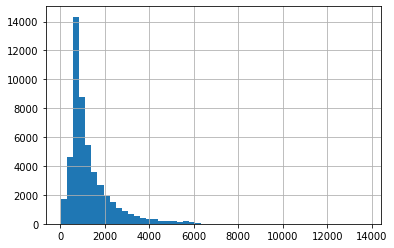

In [10]:
dataset.review.str.len().hist(bins=50)

In [11]:
dataset.review.str.len().describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review, dtype: float64

In [12]:
print("\n\n".join(list(dataset.review.sample(3))))

This game is very addictive, I kept playing it for hours straight until late at night but also the fact that you can't save a game when you are in space contributed to this, at times I just HAD to play on in order not to loose any game data.<br /><br />So yes, "Freelancer" is addictive but also quite flawed. Also for instance, something that extremely bothered me was that you couldn't skip any of the cut scene's with as a result that at times you had to watch the same few minute cut scene time after time. A great opportunity for me to multitask to check my e-mail or have a chat with my friends and more things like that, while I had to wait for the cut scene to be over.<br /><br />The story starts of promising but the further you get the more ridiculous it all gets. Also the game also ends quite abrupt, at least it did so for me. It is quite obvious that they are hinting at a upcoming sequel. I don't know if a sequel is in the works at the moment but I am sure that most likely I will pi

In [13]:
sentences = list(dataset.review)
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

labels = list(dataset.sentiment.map({'positive': 1, 'negative': 0}))

In [14]:
dataset[3:5]

,review,sentiment
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
list(zip(*(sentences[3:5], labels[3:5])))

[("[CLS] Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them. [SEP]",
  0),
 ('[CLS] Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success d

In [16]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, shuffle=True, random_state=42, test_size=0.3)

In [17]:
print(len(train_gt), len(test_gt))

35000 15000


## Inputs

In [18]:
from pytorch_transformers import BertTokenizer, BertConfig

# Подробное описание модели https://huggingface.co/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print(train_sentences[0])
print(tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 320431.65B/s]


[CLS] As much as I love trains, I couldn't stomach this movie. The premise that one could steal a locomotive and "drive" from Arkansas to Chicago without hitting another train along the way has to be right up there on the Impossible Plot lines hit board. Imagine two disgruntled NASA employees stealing the "crawler" that totes the shuttles to and fro and driving it to New York and you get the idea.<br /><br />Having said all that, it's a nice try. Wilford Brimely is at his Quaker Oats best, and Levon Helm turns a good performance as his dimwitted but well-meaning sidekick. Bob Balaban is suitably wormy as the Corporate Guy, and the "little guy takes on Goliath" story gets another airing. [SEP]
['[CLS]', 'as', 'much', 'as', 'i', 'love', 'trains', ',', 'i', 'couldn', "'", 't', 'stomach', 'this', 'movie', '.', 'the', 'premise', 'that', 'one', 'could', 'steal', 'a', 'locomotive', 'and', '"', 'drive', '"', 'from', 'arkansas', 'to', 'chicago', 'without', 'hitting', 'another', 'train', 'along'

<AxesSubplot:>

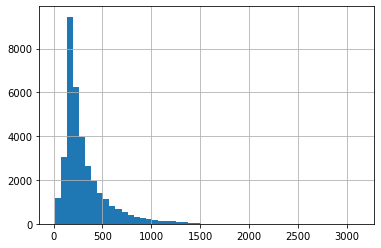

In [19]:
#only for quick analyze
series_tokenized_texts = pd.Series(tokenized_texts)
series_tokenized_texts.map(len).hist(bins=50)

In [20]:
series_tokenized_texts.map(len).describe()

count    35000.000000
mean       309.736229
std        231.378177
min         10.000000
25%        166.000000
50%        231.000000
75%        377.000000
max       3127.000000
dtype: float64

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [21]:
MAX_LEN = 500

# padding: String, 'pre' or 'post' (optional, defaults to 'pre'):
#         pad either before or after each sequence.
# truncating: String, 'pre' or 'post' (optional, defaults to 'pre'):
#        remove values from sequences larger than `maxlen`, either 
#        at the beginning or at the end of the sequences.

# возможно сентимент отзыва больше раскрывается в конце, а не в начале, 
# как следствие, может быть лучше задавать 'pre'
TRUNC_PAD_TYPE = "post"

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating=TRUNC_PAD_TYPE,
    padding=TRUNC_PAD_TYPE
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [22]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [23]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [24]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [25]:
train_labels

tensor([0, 0, 0,  ..., 0, 1, 1])

In [26]:
BATCH_SIZE = 10

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

In [27]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE*3
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [28]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач:

In [29]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [30]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=2)
model.cuda()

100%|██████████| 440473133/440473133 [00:36<00:00, 12080897.20B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [31]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



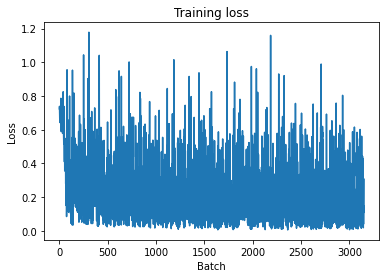

Loss на обучающей выборке: 0.22756


In [32]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

In [33]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    # изначально было np.concatenate(label_ids), но по какой то причина на этом датасете
    # такой вариант не работает, т.к. мы получаем плоский тензор, в итоге заменил на 
    # конструкцию ниже (хотя на само деле непонятно как работало раньше)
    batch_labels = np.concatenate([label_ids] if label_ids.ndim == 1 else label_ids)
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 92.06%


In [34]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 92.06%


# Оценка качества на отложенной выборке

In [35]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating=TRUNC_PAD_TYPE,
    padding=TRUNC_PAD_TYPE
)

In [36]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=BATCH_SIZE*3
)

In [37]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate([label_ids] if label_ids.ndim == 1 else label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [38]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 91.69%


In [39]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(np.array(test_labels) != np.array(test_preds)),
    len(test_labels)
))

Неправильных предсказаний: 1246/15000
